In [1]:
import os
print(os.cpu_count())

import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import h5py
from PIL import Image
from io import BytesIO

import torch
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import models

import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import roc_auc_score

import albumentations as A
from albumentations.pytorch import ToTensorV2

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

30


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


Using cuda device


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.set_float32_matmul_precision("highest")


# Set the random seed
set_seed(42)


In [3]:
def add_path(row):
    return f"../data/train-image/image/{row.isic_id}.jpg"


def add_extra_path(row):
    return f"../data/extra/malignant_images/{row.isic_id}.jpg"

train_metadata_df = pd.read_csv("../data/stratified_5_fold_train_metadata.csv")
extra_malignant_df = pd.read_csv("../data/extra_malignant.csv")
train_metadata_df["path"] = train_metadata_df.apply(lambda row: add_path(row), axis=1)
extra_malignant_df["path"] = extra_malignant_df.apply(lambda row: add_extra_path(row), axis=1)
print(f"Train: {len(train_metadata_df)} | Extra train: {len(extra_malignant_df)}")

train_metadata_df = train_metadata_df[["isic_id", "target", "fold"]]
extra_malignant_df = extra_malignant_df[["path", "target", "fold"]]


/tmp/ipykernel_479949/610898320.py:8: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata_df = pd.read_csv("../data/stratified_5_fold_train_metadata.csv")


Train: 401059 | Extra train: 9239


In [4]:
valid_df = train_metadata_df.loc[train_metadata_df.fold == 1]

In [8]:
# dataset
class SkinDataset(Dataset):
    def __init__(self, df: pd.DataFrame, file_hdf: str, transform=None):
        assert "isic_id" in df.columns
        assert "target" in df.columns

        self.fp_hdf = h5py.File(file_hdf, mode="r")
        self.isic_ids = df['isic_id'].values
        self.labels = df.target.tolist()
        self.transform = transform

    def __len__(self):
        return len(self.isic_ids)

    def __getitem__(self, idx: int):
        isic_id = self.isic_ids[idx]
        image = np.array(Image.open(BytesIO(self.fp_hdf[isic_id][()])))
        label = self.labels[idx] / 1.0
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label

    def get_class_samples(self, class_label):
        indices = [i for i, label in enumerate(self.labels) if label == class_label]
        return indices


transforms_valid = A.Compose(
    [
        A.Resize(124, 124),
        # A.Normalize(),
        ToTensorV2(),
    ]
)

In [9]:
num_workers = 24  # based on profiling

valid_dataset = SkinDataset(
    valid_df,
    "/home/ubuntu/ayusht/skin/data/train-image.hdf5",
    transform=transforms_valid,
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True,
)

In [7]:
class SkinClassifier(nn.Module):
    def __init__(self, model_name="resnet18", freeze_backbone=False, bias_value=None):
        super(SkinClassifier, self).__init__()

        # Load the specified pre-trained model
        if model_name == "resnet18":
            self.backbone = models.resnet18(weights="IMAGENET1K_V1")
            if freeze_backbone:
                self.freeze_backbone()
            num_ftrs = self.backbone.fc.in_features
            self.backbone.fc = self.get_clf_head(num_ftrs, 1, bias_value)
        elif model_name == "convnext_tiny":
            self.backbone = models.convnext_tiny(weights="IMAGENET1K_V1")
            if freeze_backbone:
                self.freeze_backbone()
            num_ftrs = self.backbone.classifier[2].in_features
            self.backbone.classifier[2] = self.get_clf_head(num_ftrs, 1, bias_value)
        elif model_name == "efficientnet_v2_s":
            self.backbone = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
            if freeze_backbone:
                self.freeze_backbone()
            num_ftrs = self.backbone.classifier[1].in_features
            self.backbone.classifier[1] = self.get_clf_head(num_ftrs, 1, bias_value)
        elif model_name == "efficientnet_v2_m":
            self.backbone = models.efficientnet_v2_m(weights="IMAGENET1K_V1")
            if freeze_backbone:
                self.freeze_backbone()
            num_ftrs = self.backbone.classifier[1].in_features
            self.backbone.classifier[1] = self.get_clf_head(num_ftrs, 1, bias_value)
        elif model_name == "mobilenet_v3_small":
            self.backbone = models.mobilenet_v3_small(weights="IMAGENET1K_V1")
            if freeze_backbone:
                self.freeze_backbone()
            num_ftrs = self.backbone.classifier[3].in_features
            self.backbone.classifier[3] = self.get_clf_head(num_ftrs, 1, bias_value)
        else:
            raise ValueError(f"Model {model_name} not supported")

    def forward(self, x):
        return self.backbone(x)

    def freeze_backbone(self):
        for param in self.backbone.parameters():
            param.requires_grad = False

        # unfreeze last conv block
        for param in self.backbone.features[7].parameters():
            param.requires_grad = True

    def get_clf_head(self, in_features, out_features, bias_value=None):
        head = nn.Linear(in_features, out_features)
        if bias_value:
            nn.init.constant_(head.bias, bias_value)
        return head

    def count_parameters(self):
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        non_trainable_params = sum(
            p.numel() for p in self.parameters() if not p.requires_grad
        )
        return trainable_params, non_trainable_params

In [59]:
# PATH = "/home/ubuntu/ayusht/skin/models/efficientnet_v2_s_g6mbhxvy_valid_loss5.4755730628967285_epoch22.bin"
# PATH = "/home/ubuntu/ayusht/skin/models/efficientnet_v2_s_x8dbzy5x_valid_loss0.36058661341667175_epoch9.bin"
# PATH = "/home/ubuntu/ayusht/skin/models/efficientnet_v2_s_my6buvg0_valid_loss2.7176403999328613_epoch15.bin"
# PATH = "/home/ubuntu/ayusht/skin/models/efficientnet_v2_s_o8gwq9mh_valid_loss1.5666254758834839_epoch28.bin"
# PATH = "/home/ubuntu/ayusht/skin/models/efficientnet_v2_s_q37691gr_valid_loss4.658746183849871e-05_epoch15.bin"
PATH = "/home/ubuntu/ayusht/skin/models/efficientnet_v2_s_et8zbzbg_valid_loss1.4331852197647095_epoch30.bin"

model = SkinClassifier(
    model_name="efficientnet_v2_s", freeze_backbone=True,
)
model = model.to(device)
model = torch.compile(model)
state_dict = torch.load(PATH, map_location=device)
model.load_state_dict(state_dict)

/tmp/ipykernel_382194/2181735567.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(PATH, map_location=device)


<All keys matched successfully>

In [60]:
@torch.inference_mode()
def infer_model(model, dataloader):
    model.eval()

    preds = []
    gts = []

    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device).flatten()

        with torch.no_grad():
            outputs = model(inputs).flatten()
            preds.extend(torch.sigmoid(outpuats))
            gts.extend(labels)

    preds = [pred.item() for pred in preds]
    gts = [gt.item() for gt in gts]

    return preds, gts

In [61]:
def comp_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80):
    v_gt = abs(np.asarray(solution.values)-1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

In [62]:
preds, gts = infer_model(model, valid_dataloader)

100%|██████████| 627/627 [00:44<00:00, 14.01it/s]


/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


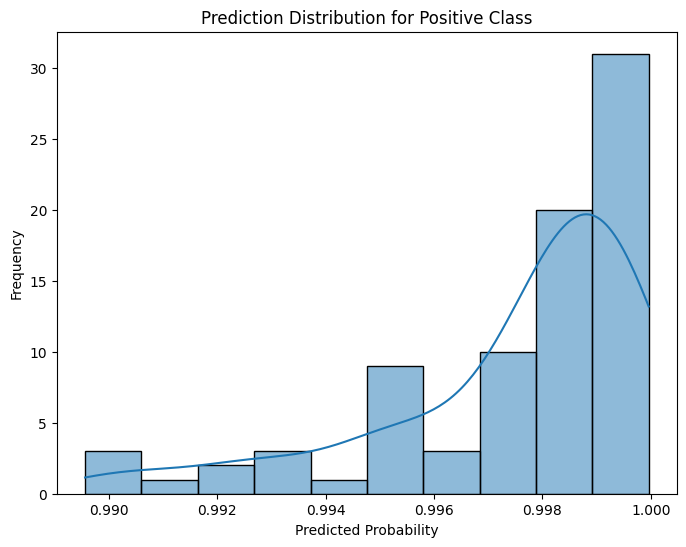

/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


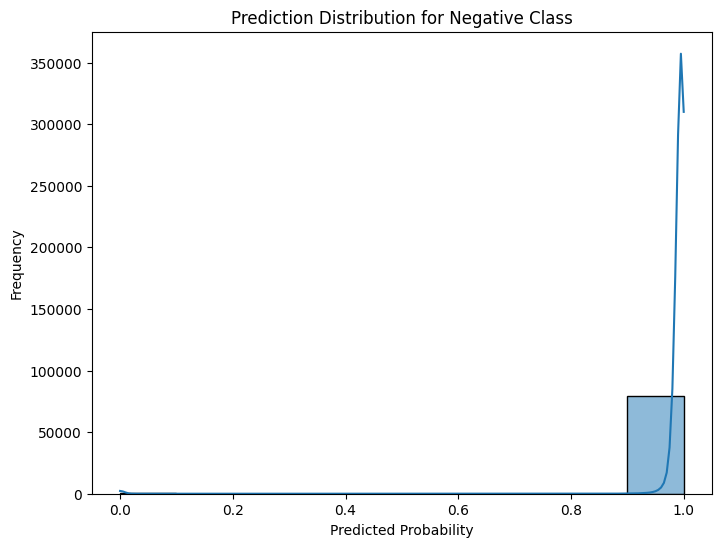

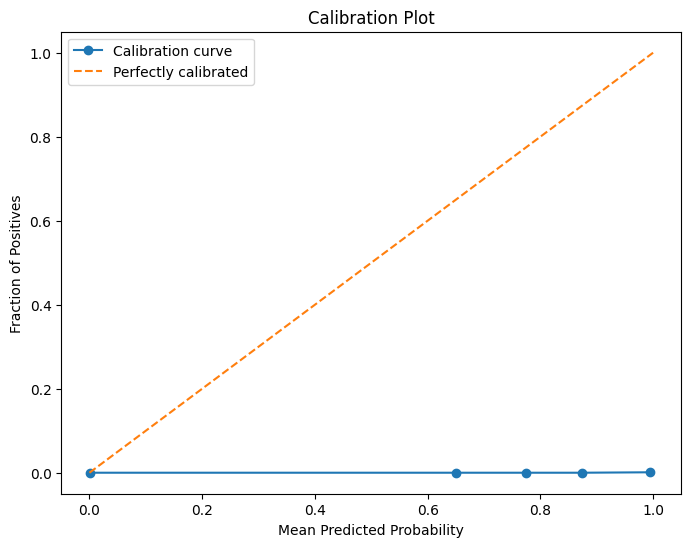

In [29]:
# Path 1
print(comp_score(
    pd.DataFrame(gts, columns=["target"]),
    pd.DataFrame(preds, columns=["prediction"]),
    ""
))

import seaborn as sns

positive_preds = np.array(preds)[np.array(gts) == 1.0]

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.histplot(positive_preds, bins=10, kde=True)
plt.title('Prediction Distribution for Positive Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

negative_preds = np.array(preds)[np.array(gts) == 0.0]

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.histplot(negative_preds, bins=10, kde=True)
plt.title('Prediction Distribution for Negative Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

from sklearn.calibration import calibration_curve

# Compute the calibration curve
prob_true, prob_pred = calibration_curve(gts, preds, n_bins=10)

# Plot the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.title('Calibration Plot')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()

0.06843427019447637


/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


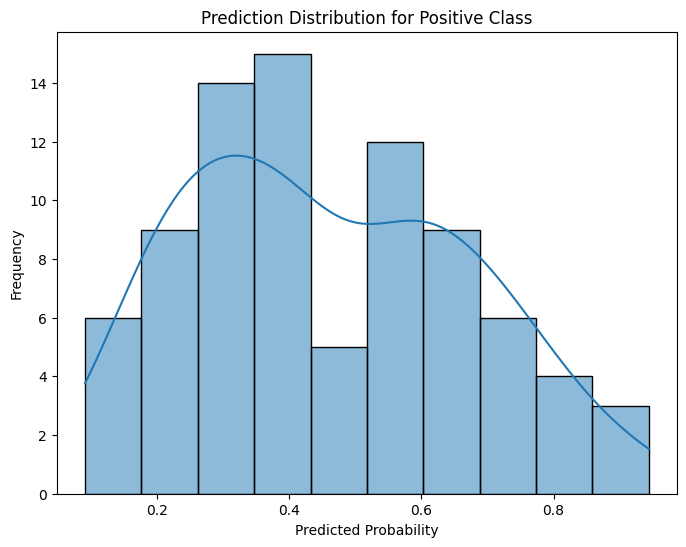

/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


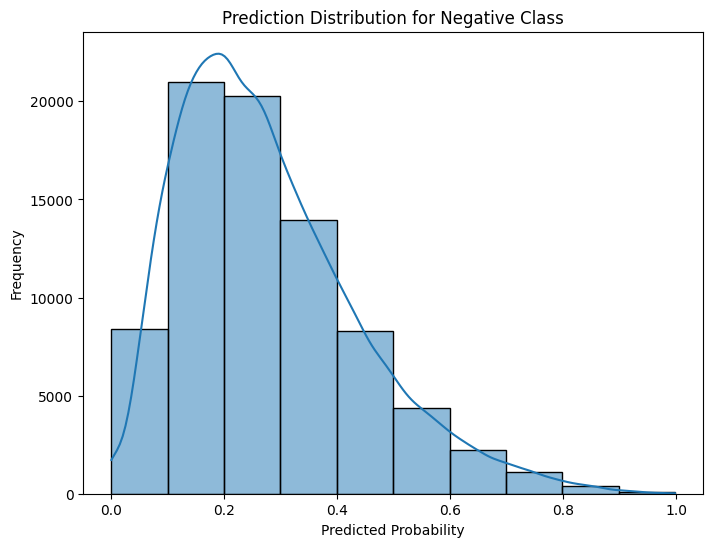

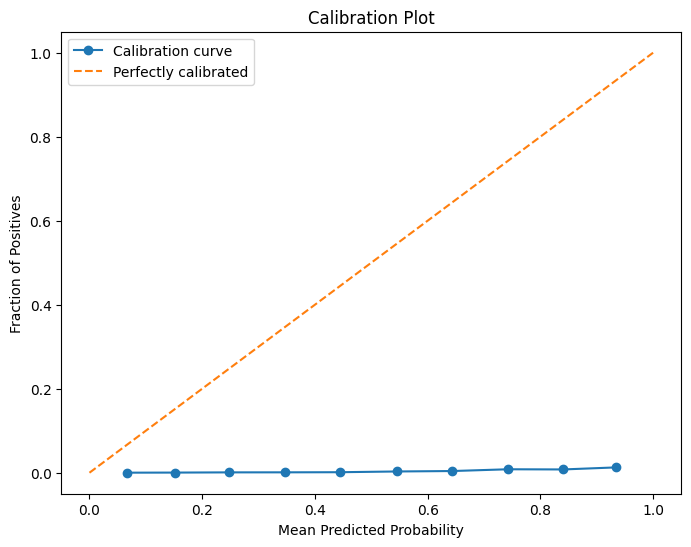

In [35]:
# Path 2
print(comp_score(
    pd.DataFrame(gts, columns=["target"]),
    pd.DataFrame(preds, columns=["prediction"]),
    ""
))

import seaborn as sns

positive_preds = np.array(preds)[np.array(gts) == 1.0]

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.histplot(positive_preds, bins=10, kde=True)
plt.title('Prediction Distribution for Positive Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

negative_preds = np.array(preds)[np.array(gts) == 0.0]

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.histplot(negative_preds, bins=10, kde=True)
plt.title('Prediction Distribution for Negative Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

from sklearn.calibration import calibration_curve

# Compute the calibration curve
prob_true, prob_pred = calibration_curve(gts, preds, n_bins=10)

# Plot the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.title('Calibration Plot')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()

0.09540446237046567


/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


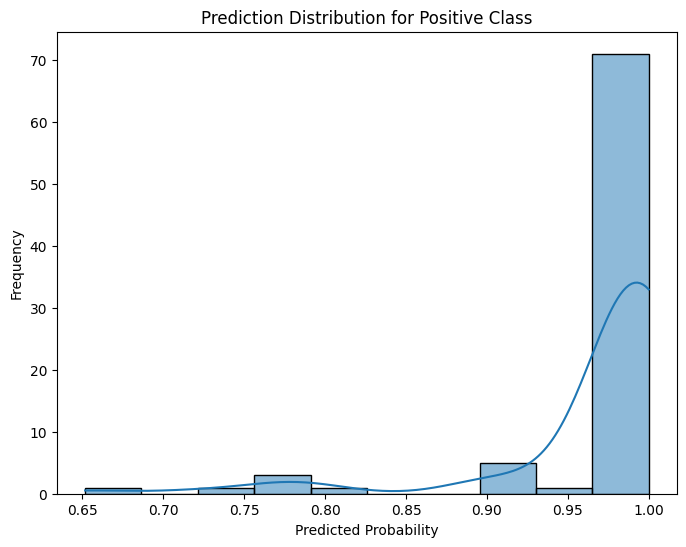

/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


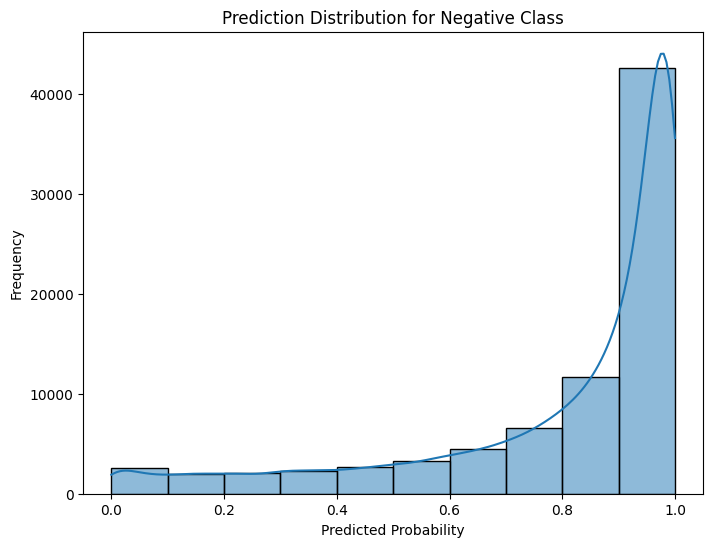

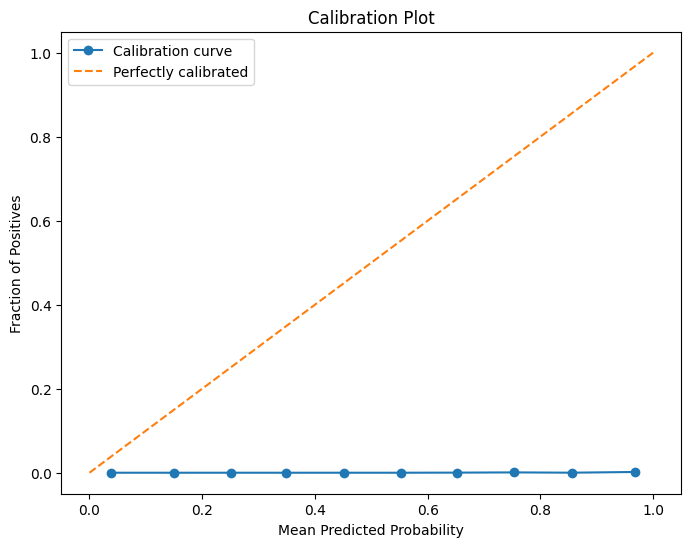

In [40]:
# Path 2
print(comp_score(
    pd.DataFrame(gts, columns=["target"]),
    pd.DataFrame(preds, columns=["prediction"]),
    ""
))

import seaborn as sns

positive_preds = np.array(preds)[np.array(gts) == 1.0]

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.histplot(positive_preds, bins=10, kde=True)
plt.title('Prediction Distribution for Positive Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

negative_preds = np.array(preds)[np.array(gts) == 0.0]

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.histplot(negative_preds, bins=10, kde=True)
plt.title('Prediction Distribution for Negative Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

from sklearn.calibration import calibration_curve

# Compute the calibration curve
prob_true, prob_pred = calibration_curve(gts, preds, n_bins=10)

# Plot the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.title('Calibration Plot')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()

0.133822008862074
AUROC: 0.91


/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


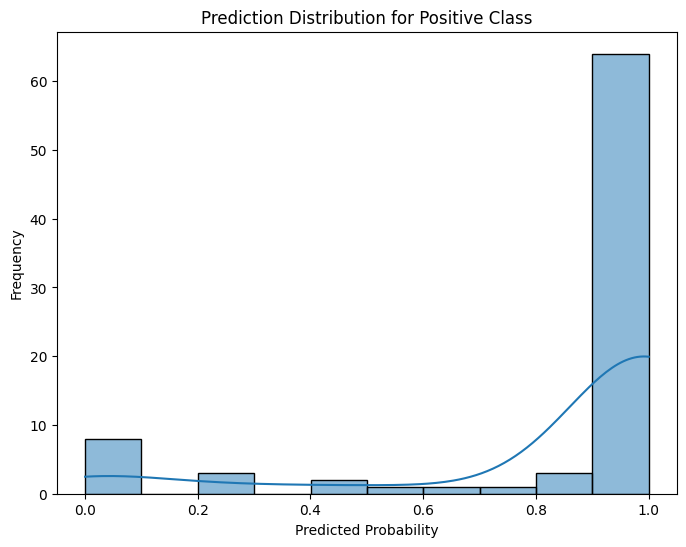

/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


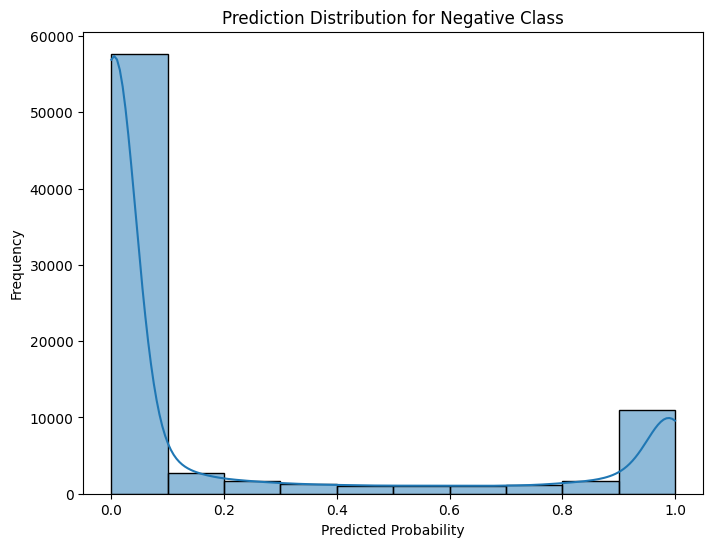

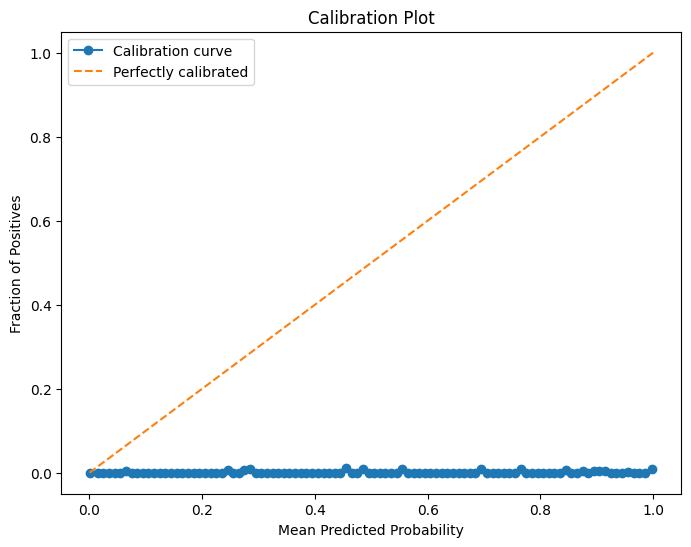

In [52]:
# Path 4
print(comp_score(
    pd.DataFrame(gts, columns=["target"]),
    pd.DataFrame(preds, columns=["prediction"]),
    ""
))

from sklearn.metrics import roc_auc_score
auroc = roc_auc_score(gts, preds)
print(f"AUROC: {auroc:.2f}")

import seaborn as sns

positive_preds = np.array(preds)[np.array(gts) == 1.0]

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.histplot(positive_preds, bins=10, kde=True)
plt.title('Prediction Distribution for Positive Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

negative_preds = np.array(preds)[np.array(gts) == 0.0]

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.histplot(negative_preds, bins=10, kde=True)
plt.title('Prediction Distribution for Negative Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

from sklearn.calibration import calibration_curve

# Compute the calibration curve
prob_true, prob_pred = calibration_curve(gts, preds, n_bins=100)

# Plot the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.title('Calibration Plot')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()

0.12113805076169297
AUROC: 0.87


/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


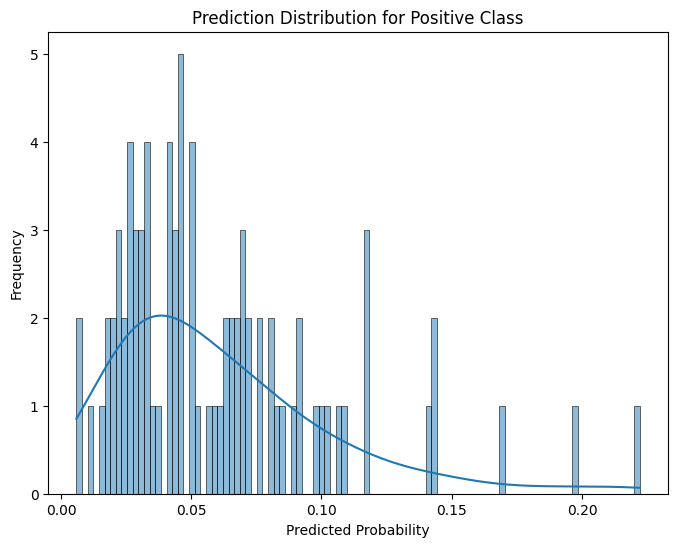

/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


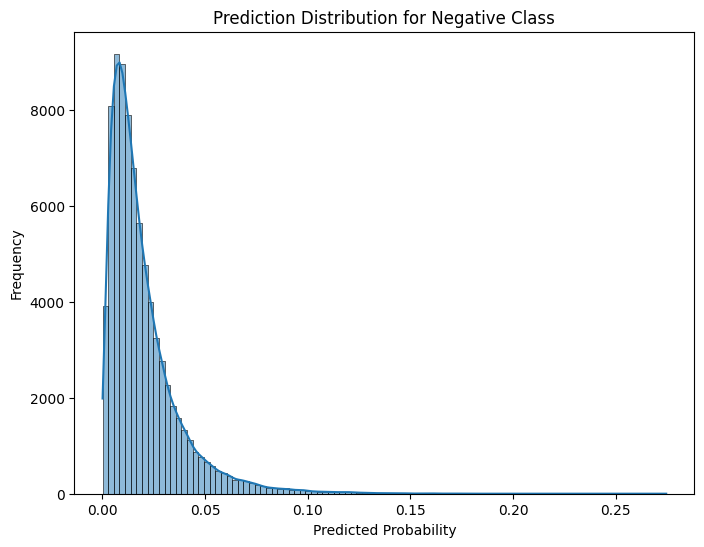

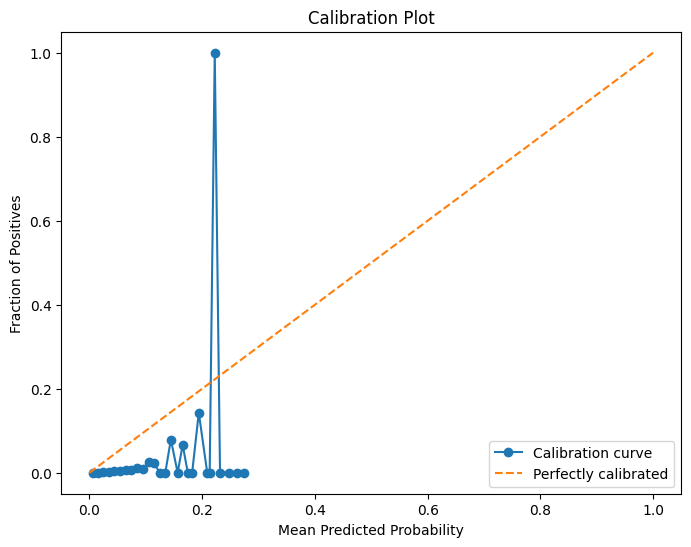

In [58]:
# Path 5
print(comp_score(
    pd.DataFrame(gts, columns=["target"]),
    pd.DataFrame(preds, columns=["prediction"]),
    ""
))

from sklearn.metrics import roc_auc_score
auroc = roc_auc_score(gts, preds)
print(f"AUROC: {auroc:.2f}")

import seaborn as sns

positive_preds = np.array(preds)[np.array(gts) == 1.0]

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.histplot(positive_preds, bins=100, kde=True)
plt.title('Prediction Distribution for Positive Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

negative_preds = np.array(preds)[np.array(gts) == 0.0]

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.histplot(negative_preds, bins=100, kde=True)
plt.title('Prediction Distribution for Negative Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

from sklearn.calibration import calibration_curve

# Compute the calibration curve
prob_true, prob_pred = calibration_curve(gts, preds, n_bins=100)

# Plot the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.title('Calibration Plot')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()

0.14407595565144032
AUROC: 0.92


/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


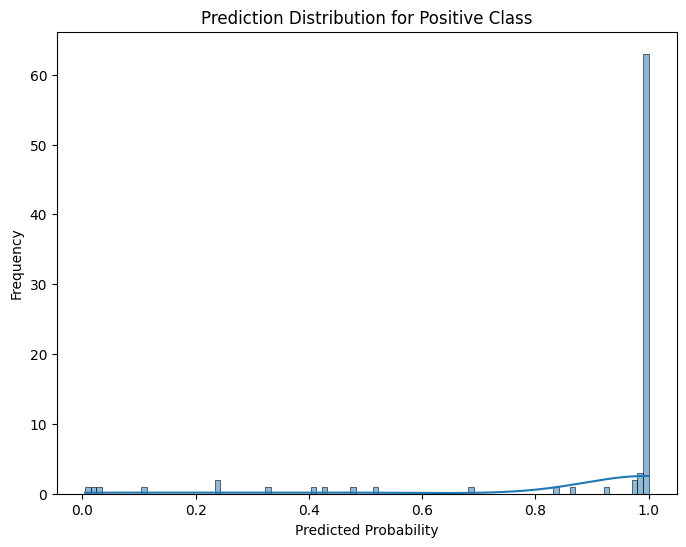

/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


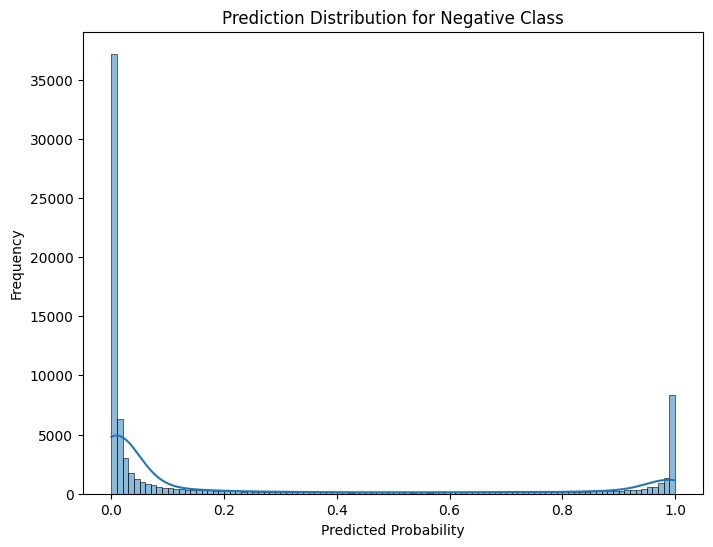

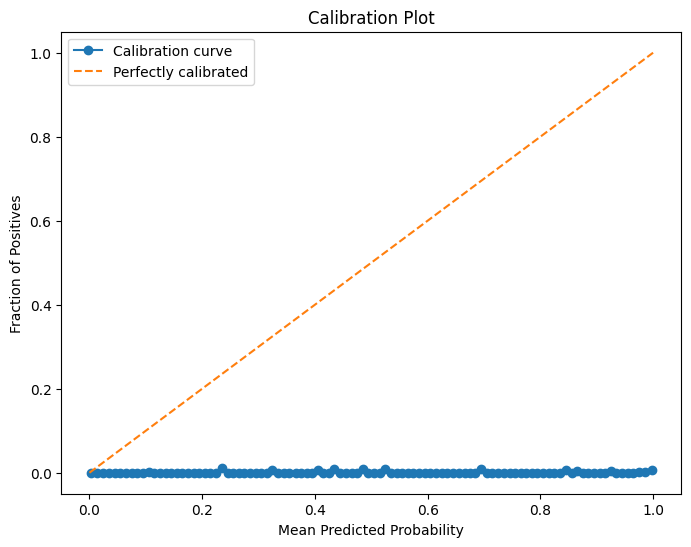

In [65]:
# Path 5
print(comp_score(
    pd.DataFrame(gts, columns=["target"]),
    pd.DataFrame(preds, columns=["prediction"]),
    ""
))

from sklearn.metrics import roc_auc_score
auroc = roc_auc_score(gts, preds)
print(f"AUROC: {auroc:.2f}")

import seaborn as sns

positive_preds = np.array(preds)[np.array(gts) == 1.0]

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.histplot(positive_preds, bins=100, kde=True)
plt.title('Prediction Distribution for Positive Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

negative_preds = np.array(preds)[np.array(gts) == 0.0]

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.histplot(negative_preds, bins=100, kde=True)
plt.title('Prediction Distribution for Negative Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

from sklearn.calibration import calibration_curve

# Compute the calibration curve
prob_true, prob_pred = calibration_curve(gts, preds, n_bins=100)

# Plot the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.title('Calibration Plot')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()